# RNN et compagnie

Nous allons voir ce qu'est un réseau de neurones récurrent, en quoi il est utile et quelles sont les applications possibles.
Face à un GROS problème des RNN, nous verrons un autre type de RNN moins naif : le Long-Short Term Memory. Enfin, face à encore une autre limitation des LSTM, nous verrons une dernière amélioration qui ouvre la porte à l'état de l'art : le mécanisme d'attention.

On arrête pas le progrès.

Teaser: s'il reste un peu de temps, je peux vous présenter rapidement -et superficiellement- les Transformers/Bert et/ou GPT 3, deux des derniers états de l'art en NLP.

#1. RNN- LSTM : théorie et applications

Jusqu'à present, nous avons vu comment traiter des donnees qui se comportent bien :
  - Des tableaux de chiffres
  - Des variables catégorielles pouvant être discretisées
  - Des images, qui sont de belles matrices de chiffres

Mais comment faire avec des données un peu plus punk ?
ex: les séries temporelles, des enregistrements audio ou des textes de journaux.

Le point commun de tous ces types de données est qu'on trouve des durées variables à l'intérieur d'un même dataset: des phrases plus ou moins longues, des enregitrements de quelques secondes vs quelques minutes, etc. De plus, l'information à date $t$ dépend souvent de l'information à $t-1$: le mot d'après dépend du mot d'avant dans une phrase, le prix d'une action dépend de son prix il y a trois heures. A cette fin, on utilise un réseau de neurones récurrent, ou RNN.

##a. RNN "vanilla"

L'idée du RNN a été proposée en 1986, quand les auteurs de [1] ont réussi à réaliser la backpropagation d'un tel réseau. De nombreuses variantes existent, mais nous présentons ici un RNN relativement agnostique à toutes ces petites variations.

![rnn unfolded](https://drive.google.com/uc?id=1cJjqpuBYDjFdcq-voRzfsRslWUuftNlC)

Un RNN est donc un réseau de neurones qui prend en compte des données séquentielles. Le but est de prendre en compte le passé pour donner du sens au présent, et de prendre en compte tous les mots d'une phrase par exemple, dans la représentation finale.

Soit une séquence de données $x$=$x_1, x_2, ...x_T$. On va entrainer le même réseau $T$ fois, soit autant que de mots dans la phrase. Chaque input sera un mélange de nouvelle information (un nouveau $x_t$) et de la connaissance passée (stockée dans l'output précédent $h_t$)

Pour les états cachés, on a donc les équations suivantes (en omettant les biais) pour la passe en avant:
\begin{eqnarray}
h_t = \theta \left( W \cdot \left[ x_t, h_{t-1}\right] \right)
& =\theta \left( W_X x_t + W_H h_{t-1}\right)
\end{eqnarray}
où
- $\theta$ est $tanh$, ou n'importe quelle fonction d'activation
- W une matrice de poids
- $x_t$ l'input à date t
- $h_{t-1}$ l'état précédent du RNN

\begin{equation}
y_t = F(W_Yh_t)
\end{equation}
où
- $y_t$ est l'output du réseau pour une date $t$
- $W_Y$ est une matrice de poids
- $F()$ est une fonction d'activation, originellement juste l'identité
- $h_t$ est l'état caché du réseau pour une date $t$
 


On peut réécrire ces équations plus formellement avec :
$h_t = \begin{pmatrix} h_{t1} & h_{t2} & \dots & h_{tH} \end{pmatrix} ^\intercal$,  $y_t = \begin{pmatrix} y_{t1} & y_{t2} & \dots & y_{tN} \end{pmatrix}^\intercal$ et $x_t = \begin{pmatrix} x_{t1} & x_{t2} & \dots & x_{tI} \end{pmatrix}^\intercal$

et en passant la notation de temps en exposant pour plus de lisibilité :
$h_{k}^t = \sum_{i=1}^I w_{ik}x_i^t + \sum_{d=1}^H w_{dk}b_{d}^{t-1}$

$b_h^t = \theta_h \left( h_k^t \right)$

$y_h^t = \sum_{h'=1}^H w_{h'k}b_h^t$




Pour plus de détails + source de l'image :
https://karpathy.github.io/2015/05/21/rnn-effectiveness/

[1] Rumelhart, D., Hinton, G. & Williams, R. Learning representations by back-propagating errors. Nature 323, 533–536 (1986). https://doi.org/10.1038/323533a0

##b.LSTM

Un RNN basique prend donc en compte ce qui se passe l'étape d'avant pour décider de l'étape d'après. Mais souvent, on a besoin d'apprendre plus loin que l'étape précédente, et de prendre en compte tout le passé, ou du moins le plus pertinent. 

Si vous voyez un individu s'avancer vers vous avec un couteau, vous allez surement courir. Sauf si vous vous souvenez que c'est votre ami Jérémy qui vous rend le couteau de votre grand-père que vous lui aviez prété.
Mais le fait que c'est le couteau de votre grand-père a peu d'importance comparé au fait que vous avez convaincu son-sa fiancé-e de convoler avec vous la veille de leur mariage. Tout l'enjeu d'un LSTM est de se souvenir des faits les plus saillants pour obtenir les meilleures représentations des situations.

Un réseau Long-Short Term Memory est un RNN avec des portes, qui gèrent l'oubli des valeurs précédentes. Dans sa version la plus courante, celle de [2], une cellule LSTM possède trois portes, que nous allons décomposer.

![lstm cell](https://drive.google.com/uc?id=1LfOd1ZkJf25tEQGo8AYqADYoYm_VNyt4)
![lstm cell](https://drive.google.com/uc?id=1Ho4pj0ybUHAUzAlyEssuF8VXc7II6vqp)

Premièrement, une "cellule" LSTM est comme une "cellule" de RNN, on lui passe un état caché et un input $x_t$ et il calcule des choses. L'état interne n'est plus l'état caché ni un simple produit suivi d'une multiplication, mais il reste simple : c'est la ligne du haut dans la cellule, $C_t^l$

Les trois portes sont trois sigmoides, qui donnent des valeurs entre 0 et 1, 0 signifiant "on laisse rien passer"/"on oublie tout" et 1 signifiant "on laisse passer toute l'information".

1. La première porte, $f_t$, s'appelle "forget gate layer" (la porte de l'oubli). Elle regarde l'état caché précédent, la nouvelle valeur, et décide de garder ou pas l'ancienne mémoire.
$$f_t = \sigma\left( W \cdot \left[ x_t, h_{t-1}\right] + b_f \right)$$
Cette équation ne vous rapelle pas quelque chose ?

2. La deuxième porte $i_t$ est l'"input gate layer"(la porte de l'entrée/la contribution). Elle décide quelles valeurs vont être modifiées/mises à jour.
En parallèle, une autre couche tanh crée de nouvelles valeurs candidates: quelles seraient les valeurs si on pouvait toutes les mettre à jour. Quand on combine les deux, cela nous donne les nouvelles valeurs à garder en mémoire.
$$i_t = \sigma \left( W_i \cdot [x_t, h_{t-1}] +b_i \right)$$
$$\tilde{C}_t = tanh \left( W_C \cdot[x_t, h_{t-1}] +b_C \right)$$

et donc :
$$\hat{C}_t = i_t * \tilde{C}_t $$

Ces deux portes apportent des modifications à l'état interne de la cellule, en décidant d'à quel point on retient le passé, et comment modifier l'état interne de la cellulle pour prendre en compte les nouvelles valeurs.

$$C_t = f_t * C_{t-1} + \hat{C}_t = f_t * C_{t-1} + i_t * \tilde{C}_t$$

3. La dernière porte est l'"output gate" (la porte de sortie). Elle ne touche plus à la mémoire de la cellule, toutes les modifications ont déjà été faites. Elle se contente de filtrer ce qu'il y a en mémoire pour donner une sortie. On prend l'état courant, que l'on fait passer par tanh (pour normaliser). En parallèle, une couche sigmoide décide de quelles valeurs on va donner en sortie. Comme pour l'input, la multiplication des 2 donne les valeurs de l'ouput.

$$o_t = \sigma \left( W_o [x_t, h_{t-1}] +b_o \right)$$
$$h_t = o_t * tanh \left( C_t \right)$$

---

Un exemple filé : prédire un mot plausible après dans la phrase "Mon frère est avocat, ma soeur est _____".
- La première porte de l'oubli permet par exemple d'oublier l'information sur le genre: nous avions un genre masculin, mais le fait d'avoir vu un nouveau sujet féminin, 'soeur', nous indique que maintenant le sujet est féminin. Quand on voit un nouveau sujet, on veut oublier le genre de l'ancien.
- La deuxième porte de l'entrée, elle, va permettre de mettre dans l'état interne (ie, en mémoire), que le sujet courant est de genre féminin.
- La porte de sortie, va elle, voir que nous avions un verbe, elle va donc surement donner de l'information concernant un nom, car souvent un nom vient apres un verbe. Il va donc donner le genre et le nombre du sujet, la conjugaison du verbe, pour accorder le nom qui vient.

Les LSTM ont été un énorme pas dans ce que l'on peut faire avec les RNN. Y a-t-il eu d'autres grands pas derrière ? Oui, il y a un consensus pour dire que le grand pas d'après a été l'attention. Ce n'est pas le seul, mais il est à la base d'un modèle qui fut état-de-l'art jusqu'en juillet 2020.

Plus de détails +source de l'image :
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

[2] Hochreiter, Sepp & Schmidhuber, Jürgen. (1997). Long Short-term Memory. Neural computation. 9. 1735-80. 10.1162/neco.1997.9.8.1735. 


##c. Méchanisme d'attention

###1. Modèle seq2seq : motivation pour l'attention

Historiquement, seq2seq est un modèle qui permet de faire de la traduction: on donne une séquence, le modèle sort une nouvelle séquence.

La mécanique basique est consitué de deux LSTM l'un après l'autre : le premier, appelé encodeur, encode toute la séquence dans le dernier état caché $h_T$. 
Le deuxième LSTM, le décodeur, prend en entrée cet encoding de la séquence et le premier mot (un token \<START\>), et sort un premier output. A chaque étape, il prend l'état caché $h'_t$ précédent et l'output qu'il vient de faire (le dernier mot prédit) pour faire une prédiction. On continue comme ça jusqu'à prédire un token de fin (\<END\>)

![lstm cell](https://drive.google.com/uc?id=13fmMDB3on4a9ZYnuYSCqpORBsxB-ESyb)

Le problème se trouve dans l'état du milieu, le fameux $c$, qui doit contenir toute l'information de la phrase. En réalité, si ce dernier output d'un LSTM est souvent suffisant pour encoder un thème, un sentiment, un topic général de la phrase, il n'est pas suffisant pour retenir toute l'information nécéssaire à une traduction. Il lui manque un élément crucial, le contexte.

###2.Attention générale

C'est là qu'apparait l'attention.
L'attention, de façon très générale, est une couche d'un réseau de neurones qui est en charge de quantifier les interdependences entre les inputs/outputs (attention générale) ou entre les inputs eux-mêmes (self-attention). Nous parlerons ici d'attention générale.

Il existe deux méthodes d'attention principales, globale\/ soft\/ Bahdanau ou local\/ hard\/ Luong du nom des deux chercheurs ayant développé ces deux attentions.

Le premier morceau reste le même, un LSTM classique avec ses inputs, ses états cachés et internes $h_t$ et $C_t$.

Lors du décodage, au lieu de passer dans la cellule le dernier $y_t$ et uniquement le dernier état caché $h_t$, on concatène au dernier état caché un vecteur de contexte. Ce vecteur de contexte cherche à montrer à quel point le dernier état caché du décodeur s'aligne avec tout les états cachés de l'encodeur.

$h_1, h_2...$ = états cachés du décodeur, 
$\bar{h}_1, \bar{h}_2, ...$ = états cachés de l'encodeur. 

On choisit d'abord un score d'alignement entre les $h$ et les $\bar{h}$. Le choix de ce score est ce qui fait la différence entre Bahdanau et Luong.

$$score$$


https://machinelearningmastery.com/attention-long-short-term-memory-recurrent-neural-networks/
https://blog.floydhub.com/attention-mechanism/

###3. Self-attention









#2. Données de travail : spam or ham ?


In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence
import re
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, LSTM, Masking, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import LambdaCallback, History

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

In [2]:
#Import the data, check it
data = pd.read_csv("https://raw.githubusercontent.com/CMallart/ateliers-NN/main/data/spamorham/SPAM%20text%20message%2020170820%20-%20Data.csv")
data.head()
data.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


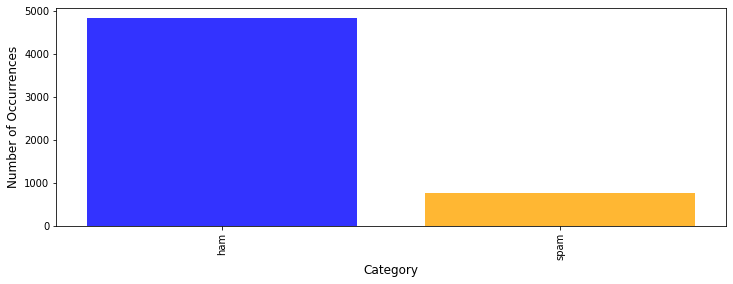

In [3]:
cnt_pro = data['Category'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(cnt_pro.index, cnt_pro.values, alpha=0.8, color=['blue', 'orange'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [4]:
# What kind of language is used, what kind of cleanup is necessary
def see_message(ind):
  mess=data.iloc[ind]["Message"]
  print(mess)
  return(mess)

In [5]:
for message in [0,15,25,35,50]:
  see_message(message)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL
Just forced myself to eat a slice. I'm really not hungry tho. This sucks. Mark is getting worried. He knows I'm sick when I turn down pizza. Lol
Yup... Ok i go home look at the timings then i msg ü again... Xuhui going to learn on 2nd may too but her lesson is at 8am
What you thinked about me. First time you saw me in class.


In [6]:
#A little cleanup is necessary 
#I won't bother cleaning up the puctuation as it is done later by keras.preprocessing.tokenizer
def clean_text(text):
  #remove the https:// stuff
  text = re.sub(r"http\S+", "", text)
  #remove the urls that don't have the http:// => solution = remove all strings that have a [some non-space characters].[two or three letters]/[some non-space characters] or [some non-space characters].[two or three letters]?[some non-space characters]
  text = re.sub(r"[^\s]*\.[a-z]{2,3}(\\|\?)*[^\s]*", "", text)
  return(text)

clean_text(see_message(15))

XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL


'XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>>  '

<font color='red'>Question 1 : Pourqui dans le code ci-dessous, utilise-t-on keras.preprocessing.pad_sequences ?</font>

In [7]:
def tokenize_and_encode(text_data):
  #fit Tokenizer : from sequences of words to lists of numbers
  tokenizer = text.Tokenizer(
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True,
            split=" ",
            oov_token="OUT_OF_VOCABULARY"
        )
  tokenizer.fit_on_texts(text_data)
  sequences = tokenizer.texts_to_sequences(text_data)
  print("Example of output : ",  sequences[2], " , for the input : ",text_data[2])

  #pad the data for input into the RNN 
  #maxlen = max([len(x) for x in sequences])
  padded_sequences = sequence.pad_sequences(sequences, padding="post", maxlen=50)

  print('Number of Unique Tokens: %d' % len(tokenizer.word_index))
  return(padded_sequences, len(tokenizer.word_index)+1)

In [8]:
#encoding the whole dataset
#targets
#Binarize categories
targets = data["Category"].apply(lambda x: 0 if x=="spam" else 1).tolist()
one_hot_targets = np.eye(2)[targets]
print(list(zip(one_hot_targets, data["Category"].tolist())))

#text
text_data, vocab_size = tokenize_and_encode(data["Message"].apply(clean_text))
text_data[15]

[(array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([1., 0.]), 'spam'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([1., 0.]), 'spam'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([1., 0.]), 'spam'), (array([1., 0.]), 'spam'), (array([0., 1.]), 'ham'), (array([1., 0.]), 'spam'), (array([1., 0.]), 'spam'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([1., 0.]), 'spam'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([1., 0.]), 'spam'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([1., 0.]), 'spam'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (array([0., 1.]), 'ham'), (a

array([4342,    3,  284,   14,  786, 1313,    6, 1009, 1010,    9,    6,
        210,   74,  152,   27, 1313,  112,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(text_data, one_hot_targets, test_size=0.33, random_state=17)

#Convert those arrays to numpy as it is the desired input to the Keras RNN
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train[0], y_train[0])

[728 471  40  28 187  45  49 131 102  24 162 547 599   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0] [0. 1.]


In [10]:
timestep = X_train[0].shape[0] # the length of a sequence (sentence, or time series, etc) is the timestep. It can vary, but we chose to pad to have a fixed length. Why ?
n_features = 1 #each input on each timestep only is one number, so it is of size 1

Pour les besoins de la démonstration, on se passe ici de cross-validation ou d'autres méthodes de validation et de tuning des hyperparamètres. Ce n'est pas rigoureux dans le cadre du développement d'un vrai modèle, il faudrait ici utiliser une fonction qui crée des sets de validation croisée comme vu dans le TP1

In [11]:
#Fonction outil pour la suite
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):
    
    # 2. Predict probabilities and stores in y_pred
    y_pred = model.predict(x, batch_size=batch_size)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

#3. Mon premier RNN

Il s'agit ici de l'architecture de base d'un RNN comme vu précédemment.

In [13]:
# Keras' input for any recurrent neural network requires the following shape : (batch_size, timestep, n_features)
#batch_size can be None, it will be input at train time, this is a default in Keras if all timesteps are equal
#timestep is the length of your sequence
#n_features is the number of features on each timestep. Had you done some embedding pre-processing, it would be larger than 1
input=Input(shape=(timestep))
embedding = Embedding(input_dim=vocab_size, output_dim=200, mask_zero=True, embeddings_initializer="zeros")(input)
rnn_layer = SimpleRNN(units = 24, activation = "sigmoid", recurrent_initializer= "random_normal")(embedding) #in : size (None, timesteps, 64), out : size (None, units)
dense_layer=Dense(2, activation = "softmax")(rnn_layer) #in : size(None, units), out : size(None,1)
model_rnn=Model(input,dense_layer)

<font color='red'> Questions : <ul>
<li>Avez-vous vu que la dernière couche dense_layer est exactement la même chose qu'une classification logit ?</li>
<li>Qu'avons-nous donc apporté comme plus-value avec le SimpleRNN ? </li>
<li>Et donc, en quoi avons-nous fait du "representation learning" ici ?</li>
</ul>
</font>

In [ ]:
#Output the model skeleton, and compile
model_rnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 200)           1764400   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 24)                5400      
_________________________________________________________________
dense (Dense)                (None, 2)                 50        
Total params: 1,769,850
Trainable params: 1,769,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 25
batch_size = 16
optim = SGD(learning_rate=0.5)
model_rnn.compile(optimizer=optim,loss="binary_crossentropy", metrics = ["binary_accuracy"])

#print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[1].get_weights())) #affiche les poids de la couche n*1, cad la couche SimpleRNN
history = History()

history=model_rnn.fit(X_train, y_train, epochs =epochs, batch_size=batch_size, verbose = 1, validation_split=0.2, callbacks = [history])#, print_weights])
#watch out, pitfall in the code concerning validation data, documented here https://stackoverflow.com/questions/61706535/keras-validation-loss-and-accuracy-stuck-at-0

Epoch 1/25
187/187 [==============================] - 4s 19ms/step - loss: 0.4272 - binary_accuracy: 0.8523 - val_loss: 0.3659 - val_binary_accuracy: 0.8795
Epoch 2/25
187/187 [==============================] - 3s 17ms/step - loss: 0.4059 - binary_accuracy: 0.8603 - val_loss: 0.3607 - val_binary_accuracy: 0.8795
Epoch 3/25
187/187 [==============================] - 3s 18ms/step - loss: 0.3653 - binary_accuracy: 0.8644 - val_loss: 0.2854 - val_binary_accuracy: 0.8996
Epoch 4/25
187/187 [==============================] - 3s 18ms/step - loss: 0.2673 - binary_accuracy: 0.8948 - val_loss: 0.2255 - val_binary_accuracy: 0.9197
Epoch 5/25
187/187 [==============================] - 3s 18ms/step - loss: 0.1536 - binary_accuracy: 0.9394 - val_loss: 0.1872 - val_binary_accuracy: 0.9371
Epoch 6/25
187/187 [==============================] - 3s 18ms/step - loss: 0.0971 - binary_accuracy: 0.9689 - val_loss: 0.7384 - val_binary_accuracy: 0.6533
Epoch 7/25
187/187 [==============================] - 3s 1

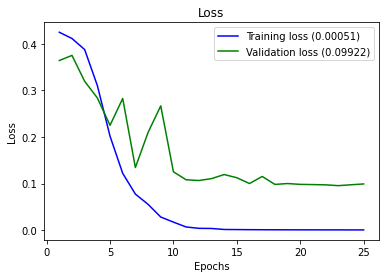

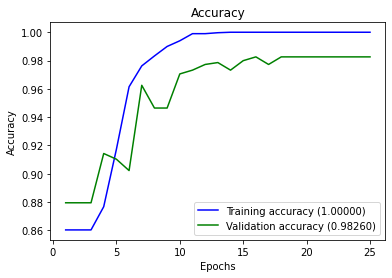

In [ ]:
plot_history(history)

Accuracy : 0.9651984774333877

Classification Report
              precision    recall  f1-score   support

           0    0.93564   0.78750   0.85520       240
           1    0.96885   0.99187   0.98022      1599

    accuracy                        0.96520      1839
   macro avg    0.95224   0.88968   0.91771      1839
weighted avg    0.96451   0.96520   0.96391      1839

[[ 189   51]
 [  13 1586]]


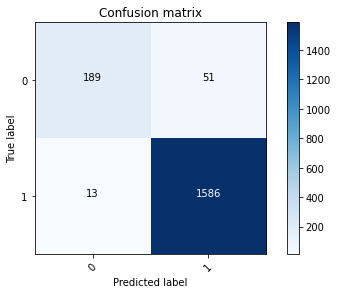

In [ ]:
full_multiclass_report(model_rnn, X_test, y_test, [0,1])

C'est beau ! Maintenant, enlevez de votre modèle la couche d'embedding. Oh-oh...

<font color='red'>Question : Quel est le problème qui vient d'arriver ?</font> (indice : regardez la loss, que devrait-elle faire quand on sur-entraine beaucoup trop ?...). Décommenter la ligne #print_weights, et relancer la cellule. Quel est le diagnostic, que s'est-il passé à votre avis?

Ce problème est un problème courant des réseaux de neurones récurrents (mais pas que !), il s'appelle le <font color='red'>Vanishing Gradient</font>, ou la disparition du gradient. Plus de détails ici :
https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484

Question subsidiaire : pourquoi ce n'est arrivé qu'après avoir retiré la couche d'embedding ? (en réalité, il suffisait d'enlever mask_zero= True...)

#4. LSTM, évolution du RNN

Des solutions au gradient qui disparait sont:
  - changer de fonction d'activation, sigmoid est bien identifié pour poser des problèmes. (pourquoi ?)
  - bien initialiser les poids (pourquoi ?)
  - ajouter des couches de normalisation (pourquoi ?)
  - avec tensorflow, masquer proprement (nous venons de le voir)
Dans le cas inverse, un gradient qui explose, souvent, on clippe le gradient.

Le LSTM résout plusieurs problèmes liées aux RNN de base, mais surtout celui du gradient qui disparait ou explose. Il permet aussi plus de finesse dans ce dont on se "souvient" ou pas dans le réseau.

---

Nous allons reprendre notre problème initial de classification de messages, mais maintenant avec un LSTM, et des fonctions d'activation plus fines.

Pour le LSTM, la documentation Keras est bien faite :
https://keras.io/api/layers/recurrent_layers/lstm/ et 
https://keras.io/api/layers/activations/

---

Attention, le choix par défaut est quand même un choix ! Soyez au moins conscients d'avoir choisi telle fonction d'activation ou telle initialisation, car nous avons vu que cela peut avoir de grosses conséquences. 

In [ ]:
#Modele a completer
#input=Input(shape=(timestep,n_features))
"""
LSTM
activation réfléchie
Dense
"""
#model_lstm=Model(input,dense_layer)

input=Input(shape=(timestep))
embedding = Embedding(input_dim=vocab_size, output_dim=200, mask_zero=True)(input)
lstm_layer = LSTM(units = 64, recurrent_activation = "relu")(embedding)
dense_layer = Dense(2, activation = "relu")(lstm_layer)

model_lstm=Model(input,dense_layer)

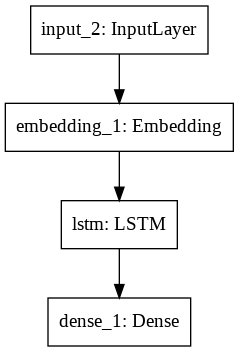

In [ ]:
from keras.utils import plot_model
plot_model(model_lstm)

In [ ]:
epochs = 25
batch_size = 16
optim = Adam()
model_lstm.compile(optimizer=optim,loss="binary_crossentropy", metrics = ["binary_accuracy"])

history = History()
#print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[1].get_weights()))

history=model_lstm.fit(X_train, y_train, epochs =epochs, batch_size=batch_size, verbose = 1, validation_split=0.2, callbacks = [history]) #, print_weights])


Epoch 1/25
187/187 [==============================] - 12s 62ms/step - loss: 1.2081 - binary_accuracy: 0.7026 - val_loss: 0.1923 - val_binary_accuracy: 0.9518
Epoch 2/25
187/187 [==============================] - 11s 60ms/step - loss: 0.1714 - binary_accuracy: 0.9548 - val_loss: 0.1269 - val_binary_accuracy: 0.9705
Epoch 3/25
187/187 [==============================] - 11s 60ms/step - loss: 0.0643 - binary_accuracy: 0.9878 - val_loss: 0.0839 - val_binary_accuracy: 0.9833
Epoch 4/25
187/187 [==============================] - 11s 59ms/step - loss: 0.0402 - binary_accuracy: 0.9945 - val_loss: 0.0791 - val_binary_accuracy: 0.9859
Epoch 5/25
187/187 [==============================] - 11s 59ms/step - loss: 0.0338 - binary_accuracy: 0.9956 - val_loss: 0.0974 - val_binary_accuracy: 0.9873
Epoch 6/25
187/187 [==============================] - 11s 60ms/step - loss: 0.0311 - binary_accuracy: 0.9967 - val_loss: 0.0905 - val_binary_accuracy: 0.9886
Epoch 7/25
187/187 [==============================] 

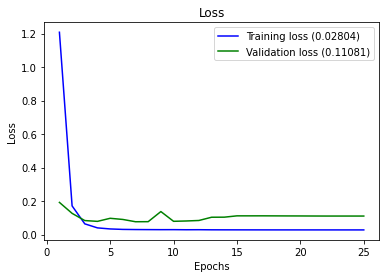

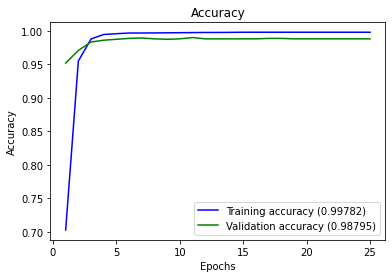

Accuracy : 0.9858618814573138

Classification Report
              precision    recall  f1-score   support

           0    0.98198   0.90833   0.94372       240
           1    0.98639   0.99750   0.99192      1599

    accuracy                        0.98586      1839
   macro avg    0.98419   0.95292   0.96782      1839
weighted avg    0.98582   0.98586   0.98563      1839

[[ 218   22]
 [   4 1595]]


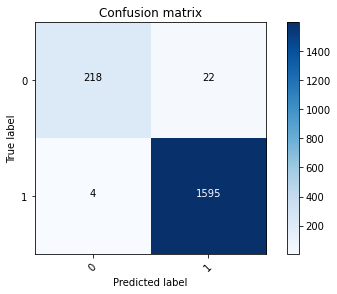

In [ ]:
plot_history(history)
full_multiclass_report(model_lstm, X_test, y_test, [0,1])

#5. Attention

Code de l'attention repris de ce blog :
https://matthewmcateer.me/blog/getting-started-with-attention-for-classification/

Keras possède aussi un layer d'Attention selon Luong et d'attention selon Badanau https://keras.io/api/layers/attention_layers/additive_attention/.
Je ne l'utilise pas car je n'arrive pas à voir explicitement à quoi correspondent key et value dans les calculs.

Cette attention est un many-to-one, prenant donc les outputs d'un LSTM et applicant l'attention pour obtenir seulement le dernier output, car nous faisons de la classification. Pour de la traduction par exemple, la couche serait différente.

In [178]:
#class for Bahnadau attention (additive attention)
from tensorflow.keras import Model
import tensorflow as tf
class AttentionB(Model):
    def __init__(self, units, output_dim, name="attention",**kwargs):
        super(AttentionB, self).__init__(name=name)
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        self.U = Dense(ouput_dim, activation= "tanh")

    def call(self, h_s_bar, h_t):
        #reshape h_t from (batch_size, hidden size) to (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(h_t, 1)

        # the shape of the score tensor is (batch_size, max_length, units)
        #units is the number of hidden units in the encoder LSTM
        score = tf.nn.tanh(self.W1(h_s_bar) + self.W2(hidden_with_time_axis))
        print("score:", score.shape)

        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        print("attention weights:", attention_weights.shape)
          
        # context_vector shape after sum == (batch_size, hidden_size) #hidden_size = size of the hidden vector h_t that we input, not number of units nodes ! so hidden_size = size input in LSTM
        context_vector = attention_weights * h_s_bar
        print("context vector pre-sum:", context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        print("context vector", context_vector.shape)

        concat_att_state= tf.concat([context_vector, h_t], 1)
        print("concat att et ht:", concat_att_state.shape)
        attention_vector = self.U(concat_att_state)
        print("attention vector:", attention_vector.shape)
        return  attention_vector, attention_weights

In [186]:
#class for Luong attention (multiplicative attention)
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Lambda, dot, Activation, concatenate
import tensorflow as tf
class AttentionL(Model):
    def __init__(self, output_dim=128, name="attention",**kwargs):
        super(AttentionL, self).__init__(name=name)
        self.output_dim =output_dim
        self.U = Dense(output_dim, activation ="tanh", name="attention_vector", use_bias=False)

    def call(self, encoder_hidden_states, h_t):
        hidden_size = int(encoder_hidden_states.shape[2])
        self.W = Dense(hidden_size)
        self.V = Dense(1)
        #print("encoder_h_s:", encoder_hidden_states.shape)
        #print("lst hidden state:", h_t.shape)

        # the shape of the score tensor is (batch_size, max_length, units)
        score_first_part = self.W(encoder_hidden_states) #that is the W*h_s_bar in the slides' equations
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        #print("score part 1:", score_first_part.shape)

        h_t_with_time_axis = tf.expand_dims(h_t, 1)
        #print("h_t_with_time_axis:",  h_t_with_time_axis.shape)
        score =  dot([score_first_part, h_t_with_time_axis], [2, 2], name='attention_score') # that is the h_t*W*h_s_bar in the slides' equations
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        #print("score:", score.shape)

        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        #print("attention weights:", attention_weights.shape)
          
        # context_vector shape after sum == (batch_size, hidden_size) #hidden_size = size of the hidden vector h_t that we input, not number of units nodes ! so hidden_size = size input in LSTM
        context_vector = attention_weights * encoder_hidden_states
        #print("context vector pre-sum:", context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        #print("context vector", context_vector.shape)

        concat_att_state= tf.concat([context_vector, h_t], 1)
        #print("concat att et ht:", concat_att_state.shape)
        attention_vector = self.U(concat_att_state)
        #print("attention vector:", attention_vector.shape)
        return  attention_vector, attention_weights

In [187]:
input=Input(shape=(timestep))
embedding = Embedding(input_dim=vocab_size, output_dim=200, mask_zero=True)(input)
(lstm_seq, state_h, state_c) = LSTM(units = 64, recurrent_activation = "relu", return_sequences=True, return_state=True)(embedding)
av, attention_weights = AttentionL(128, name="attention")(lstm_seq, state_h)
dense_layer = Dense(2, activation = "relu")(av)
model_att = Model(inputs=input, outputs=dense_layer)

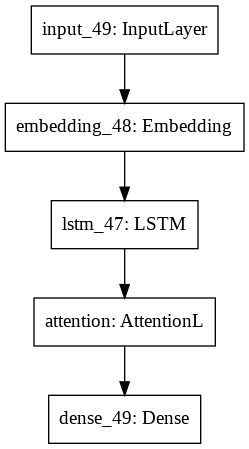

In [188]:
from keras.utils import plot_model
plot_model(model_att)

In [189]:
model_att.summary()

Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 50, 200)      1764400     input_49[0][0]                   
__________________________________________________________________________________________________
lstm_47 (LSTM)                  [(None, 50, 64), (No 67840       embedding_48[0][0]               
__________________________________________________________________________________________________
attention (AttentionL)          ((None, 128), (None, 20546       lstm_47[0][0]                    
                                                                 lstm_47[0][1]        

In [190]:
#model for attention weights, share the exact same layers as our main model
a_w_model = Model(inputs= model_att.inputs, outputs = model_att.get_layer("attention").output)

In [191]:
from tensorflow.keras.callbacks import Callback

# to visualise, we use the great boutny of keras' functional model.
#we create our model that gets trained. And then on the side, we create another model, that shares exactly the same layers, but stops at the attention layer
#the first model will train, and because they share layers, the layers of the visu model will also train
#it suffices to get the output of the visu model to get the attention weights of the trained model

class VisualiseAttentionMap(Callback):
    def __init__(self, attention_weights_model, x_test, output_dir=None):
        super(Callback, self).__init__()
        self.visu_model = attention_weights_model
        # best_weights to store the weights at which the minimum loss occurs.
        self.x_test = x_test
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        attention_map = self.visu_model.predict(self.x_test)
        #print(attetion_map.shape)
        # top is attention map.
        # bottom is ground truth.
        #plt.imshow(np.concatenate([attention_map, x_test_mask]), cmap='hot')

        print(attention_map)

        plt.imshow(attention_map, cmap='hot')

        iteration_no = str(epoch).zfill(3)
        plt.axis('off')
        plt.title(f'Iteration {iteration_no} / {max_epoch}')
        if self.output_dir is not None :
          if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
          plt.savefig(f'{output_dir}/epoch_{iteration_no}.png')
        plt.show()

In [192]:
epochs = 25
batch_size = 16
optim = Adam()
model_att.compile(optimizer=optim,loss="binary_crossentropy", metrics = ["binary_accuracy"])

history = History()
#attmap = VisualiseAttentionMap(a_w_model, x_test=X_train[0:10])
model_att.fit(X_train, y_train, epochs =epochs, batch_size=128, verbose = 1, validation_split=0.2)

Epoch 1/25


ValueError: ignored